In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-08-30 11:30:41--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.03s   

2020-08-30 11:30:41 (2.36 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



# Prepare time series data

## read csv data into lists

In [5]:
import csv
temperatures = []
timestamps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader) # drop the first line containing header
  time_step=0
  for line in reader:
    temperatures.append(float(line[1])) # sun temperatures are stored in the second columns
    timestamps.append(time_step)
    time_step += 1


In [6]:
len(temperatures)

3650

In [7]:
len(timestamps)

3650

In [8]:
# turn lists into np.array
temperatures = np.array(temperatures)
timestamps = np.array(timestamps)

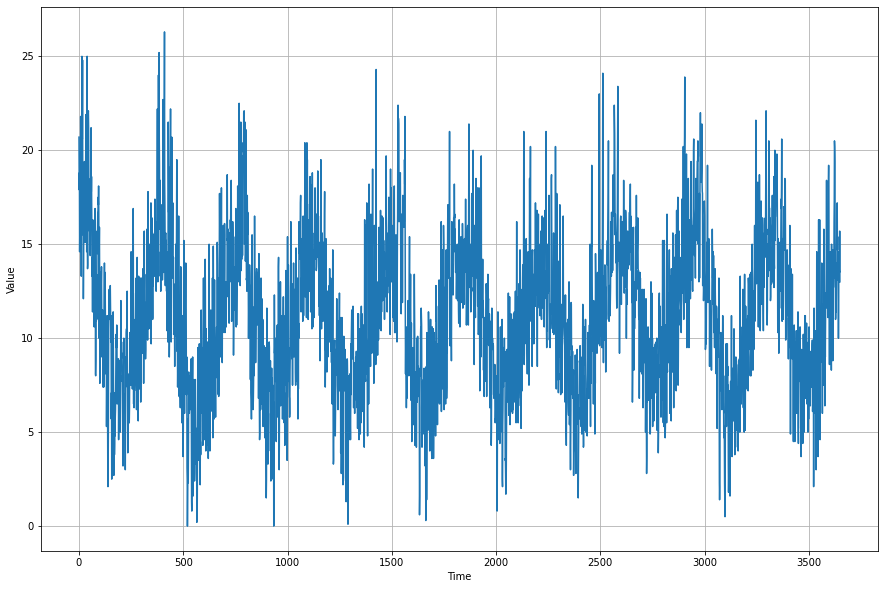

In [9]:
plt.figure(figsize=(15,10))
plot_series(timestamps, temperatures)

Because the total timestamps are around 3600. So we can divide the timestamps into two parts as training and validation set with a ratio of 2500:1000

In [11]:
train_steps = 2500
time_train = timestamps[:train_steps]
time_val = timestamps[train_steps:]

x_train = temperatures[:train_steps]
x_val = temperatures[train_steps:]

In [16]:
# helper func windows sampling
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [17]:
tf.random.set_seed(23)
np.random.seed(23)

window_size = 100
batch_size = 256

train_set = windowed_dataset(x_train, window_size, batch_size, 1000)
print(train_set) # three dimensions
print(x_train.shape)


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


## Model

In [18]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [19]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 1s 59ms/step - loss: 41.2470 - mae: 41.7460
Epoch 2/100
10/10 [==============================] - 1s 61ms/step - loss: 39.4701 - mae: 39.9691
Epoch 3/100
10/10 [==============================] - 1s 64ms/step - loss: 36.7910 - mae: 37.2899
Epoch 4/100
10/10 [==============================] - 1s 63ms/step - loss: 33.5989 - mae: 34.0979
Epoch 5/100
10/10 [==============================] - 1s 63ms/step - loss: 30.0315 - mae: 30.5306
Epoch 6/100
10/10 [==============================] - 1s 63ms/step - loss: 26.0926 - mae: 26.5916
Epoch 7/100
10/10 [==============================] - 1s 63ms/step - loss: 21.7482 - mae: 22.2469
Epoch 8/100
10/10 [==============================] - 1s 62ms/step - loss: 16.9891 - mae: 17.4857
Epoch 9/100
10/10 [==============================] - 1s 68ms/step - loss: 12.3231 - mae: 12.8097
Epoch 10/100
10/10 [==============================] - 1s 68ms/step - loss: 9.8269 - mae: 10.3109
Epoch 11/100
10/10 [==========

(1e-08, 0.0001, 0.0, 60.0)

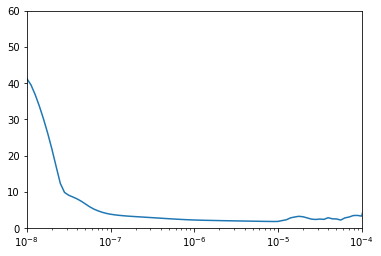

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(23)
np.random.seed(23)
train_set = windowed_dataset(x_train, window_size, batch_size, 1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
10/10 [==============================] - 1s 59ms/step - loss: 31.8029 - mae: 32.3007
Epoch 2/150
10/10 [==============================] - 1s 67ms/step - loss: 21.7594 - mae: 22.2560
Epoch 3/150
10/10 [==============================] - 1s 62ms/step - loss: 18.1360 - mae: 18.6342
Epoch 4/150
10/10 [==============================] - 1s 66ms/step - loss: 13.4278 - mae: 13.9262
Epoch 5/150
10/10 [==============================] - 1s 60ms/step - loss: 12.4275 - mae: 12.9256
Epoch 6/150
10/10 [==============================] - 1s 62ms/step - loss: 10.3231 - mae: 10.8208
Epoch 7/150
10/10 [==============================] - 1s 59ms/step - loss: 9.2029 - mae: 9.7000
Epoch 8/150
10/10 [==============================] - 1s 59ms/step - loss: 8.4632 - mae: 8.9594
Epoch 9/150
10/10 [==============================] - 1s 59ms/step - loss: 7.4300 - mae: 7.9243
Epoch 10/150
10/10 [==============================] - 1s 64ms/step - loss: 6.9246 - mae: 7.4182
Epoch 11/150
10/10 [=================

In [22]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

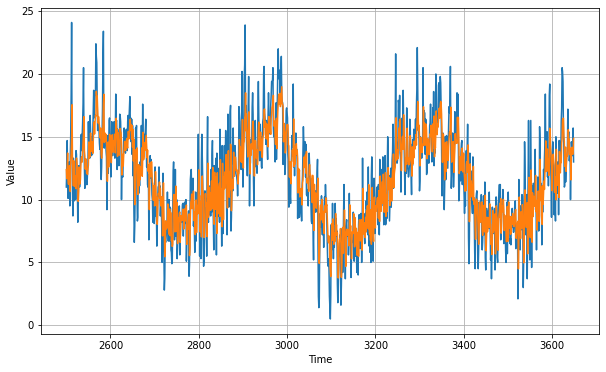

In [26]:
rnn_forecast = model_forecast(model, temperatures[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[train_steps - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_val, x_val)
plot_series(time_val, rnn_forecast)

In [28]:
tf.keras.metrics.mean_absolute_error(x_val, rnn_forecast).numpy()

1.7961186